# 04: PINN - Heat transfer

In [12]:
import numpy as np
import torch

class DataGeneratorXY:
    """ Generates 2D collocation grid for a rectangular domain
    """
    def __init__(self,
                 X=[0., 1.],
                 Y=[0., 1.],
                 targets=['domain', 'bc-left', 'bc-right', 'bc-bot', 'bc-top'],
                 num_sample=10000):
        'Initialization'
        self.Xdomain = X
        self.Ydomain = Y
        self.targets = targets
        self.num_sample = num_sample
        self.input_data = None
        self.target_data = None
        self.set_data()

    def __len__(self):
        return self.input_data[0].shape[0]

    def set_data(self):
        self.input_data, self.target_data = self.generate_data()

    def get_data(self):
        return self.input_data, self.target_data

    def generate_data(self):
        num_sample = int(self.num_sample/2)
        counter = 0

        # domain points
        x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
        y_dom = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample)
        ids_dom = np.arange(x_dom.shape[0])
        counter += ids_dom.size

        # bc points
        num_sample_per_edge = int(num_sample/4)

        # left bc points
        x_bc_left = np.full(num_sample_per_edge, self.Xdomain[0])
        y_bc_left = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
        ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
        counter += ids_bc_left.size

        # right bc points
        x_bc_right = np.full(num_sample_per_edge, self.Xdomain[1])
        y_bc_right = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
        ids_bc_right = np.arange(x_bc_right.shape[0]) + counter
        counter += ids_bc_right.size

        # bot bc points
        x_bc_bot = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample_per_edge)
        y_bc_bot = np.full(num_sample_per_edge, self.Ydomain[0])
        ids_bc_bot = np.arange(x_bc_bot.shape[0]) + counter
        counter += ids_bc_bot.size

        # top bc points
        x_bc_top = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample-num_sample_per_edge)
        y_bc_top = np.full(num_sample-num_sample_per_edge, self.Ydomain[1])
        ids_bc_top = np.arange(x_bc_top.shape[0]) + counter
        counter += ids_bc_top.size

        ids_bc = np.concatenate([ids_bc_left, ids_bc_right, ids_bc_bot, ids_bc_top])
        ids_all = np.concatenate([ids_dom, ids_bc])

        ids = {
            'domain': ids_dom,
            'bc-left': ids_bc_left,
            'bc-right': ids_bc_right,
            'bc-bot': ids_bc_bot,
            'bc-top': ids_bc_top,
            'bc': ids_bc,
            'all': ids_all
        }

        assert all([t in ids.keys() for t in self.targets]), \
          'accepted target types: {}'.format(ids.keys())

        input_data = [
            torch.tensor(np.concatenate([x_dom, x_bc_left, x_bc_right, x_bc_bot, x_bc_top]).reshape(-1,1), dtype=torch.float32, requires_grad=True),
            torch.tensor(np.concatenate([y_dom, y_bc_left, y_bc_right, y_bc_bot, y_bc_top]).reshape(-1,1), dtype=torch.float32, requires_grad=True),
        ]

        total_sample = input_data[0].shape[0]

        target_data = []
        for i, tp in enumerate(self.targets):
            zeros_tensor = torch.zeros(len(ids[tp]), 1, dtype=torch.float32)
            target_data.append(
                (ids[tp], zeros_tensor)
            )

        return input_data, target_data


<ipython-input-19-d159df7bdc83>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x_data, dtype=torch.float32, requires_grad=True)
<ipython-input-19-d159df7bdc83>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y_data, dtype=torch.float32, requires_grad=True)


Training progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0/1000, Loss: 1.1403765678405762
Epoch 100/1000, Loss: 0.2852590084075928
Epoch 200/1000, Loss: 0.2204679548740387
Epoch 300/1000, Loss: 0.17355327308177948
Epoch 400/1000, Loss: 0.13387514650821686
Epoch 500/1000, Loss: 0.11003094166517258
Epoch 600/1000, Loss: 0.09422235190868378
Epoch 700/1000, Loss: 0.09743916988372803
Epoch 800/1000, Loss: 0.0716414824128151
Epoch 900/1000, Loss: 0.06318959593772888


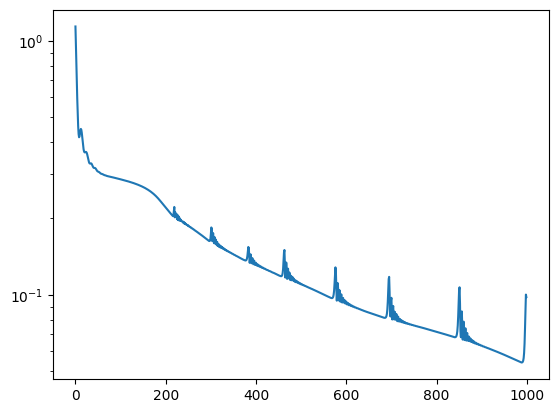

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

# Define the neural network model
class HeatNet(nn.Module):
    def __init__(self):
        super(HeatNet, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1)
        )

    def forward(self, x, y):
        x = x.view(-1, 1)
        y = y.view(-1, 1)
        xy = torch.cat([x, y], dim=1)
        T = self.hidden_layers(xy)
        return T

    def loss_function(self, x, y):
        T = self.forward(x, y)
        T_x = torch.autograd.grad(T.sum(), x, create_graph=True)[0]
        T_y = torch.autograd.grad(T.sum(), y, create_graph=True)[0]
        T_xx = torch.autograd.grad(T_x.sum(), x, create_graph=True)[0]
        T_yy = torch.autograd.grad(T_y.sum(), y, create_graph=True)[0]
        # PDE loss
        loss_PDE = ((T_xx + T_yy)**2).mean()

        # BC loss
        mask_left = (x == 0)
        mask_right = (x == 1)
        mask_bottom = (y == 0)
        mask_top1 = (y == 1) & (x < 0.5)
        mask_top2 = (y == 1) & (x >= 0.5)

        loss_left = (T[mask_left]**2).mean()
        loss_right = (T[mask_right]**2).mean()
        loss_bottom = (T[mask_bottom]**2).mean()
        loss_top1 = ((T[mask_top1] - 2*x[mask_top1])**2).mean()
        loss_top2 = ((T[mask_top2] - (2 - 2*x[mask_top2]))**2).mean()

        loss = loss_PDE + loss_left + loss_right + loss_bottom + loss_top1 + loss_top2
        return loss

# Instantiate the model
model = HeatNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the training data
dg = DataGeneratorXY([0.,1.], [0.,1.], num_sample=10000,
                     targets=['domain', 'bc-top', 'bc-top', 'bc-left', 'bc-right', 'bc-bot'])
input_data, target_data = dg.get_data()
x_data, y_data = input_data

# Convert numpy arrays to PyTorch tensors
x_data = torch.tensor(x_data, dtype=torch.float32, requires_grad=True)
y_data = torch.tensor(y_data, dtype=torch.float32, requires_grad=True)

# Training loop
losses = []
epochs = 1000
for epoch in tqdm(range(epochs), desc='Training progress'):
    optimizer.zero_grad()
    loss = model.loss_function(x_data, y_data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')


# Plot the loss
plt.figure()
plt.semilogy(losses)
plt.show()


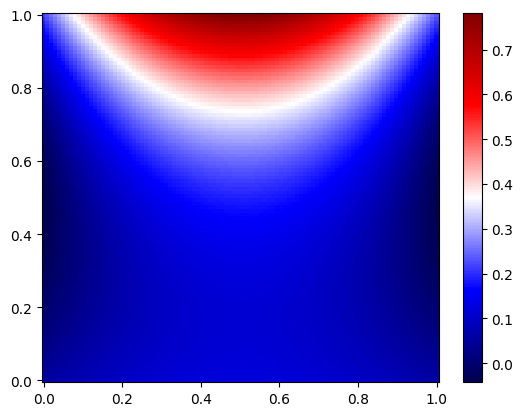

In [20]:
x_test, y_test = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))

# Flatten and stack tensors
# Flatten tensors
x_test_flat = torch.tensor(x_test.flatten(), dtype=torch.float32, requires_grad=True)
y_test_flat = torch.tensor(y_test.flatten(), dtype=torch.float32, requires_grad=True)

# Pass through the model
T_test_flat = model(x_test_flat, y_test_flat)
T_test = T_test_flat.detach().numpy().reshape(100, 100)

plt.pcolor(x_test, y_test, T_test, cmap='seismic', shading='auto')
plt.colorbar()
plt.show()

### DeepXDE implementation

In [1]:
!pip3 install deepxde --quiet

In [4]:
!DDE_BACKEND=tensorflow

In [5]:
import numpy as np
import deepxde as dde
from deepxde.backend import pytorch as dde

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return dy_xx + dy_yy

def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def boundary_b(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_t1(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1) and x[0] < 0.5

def boundary_t2(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1) and x[0] >= 0.5

def func_t1(x):
    return 2 * x[:, 0:1]

def func_t2(x):
    return 2 - 2 * x[:, 0:1]

# Geometry and time domain
geom = dde.geometry.Rectangle([0, 0], [1, 1])

# Boundary conditions
bc_l = dde.DirichletBC(geom, lambda x: 0, boundary_l)
bc_r = dde.DirichletBC(geom, lambda x: 0, boundary_r)
bc_b = dde.DirichletBC(geom, lambda x: 0, boundary_b)
bc_t1 = dde.DirichletBC(geom, func_t1, boundary_t1)
bc_t2 = dde.DirichletBC(geom, func_t2, boundary_t2)

# Define the data
data = dde.data.PDE(
    geom,
    pde,
    [bc_l, bc_r, bc_b, bc_t1, bc_t2],
    num_domain=10000,
    num_boundary=2000
)

# Define the neural network
net = dde.nn.FNN([2] + [40] * 4 + [1], "tanh", "Glorot uniform")

# Define the model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.071709 s

'compile' took 0.853986 s

Training model...

0         [1.24e-02, 3.11e-03, 9.70e-02, 2.58e-02, 1.86e-01, 1.54e-01]    [1.24e-02, 3.11e-03, 9.70e-02, 2.58e-02, 1.86e-01, 1.54e-01]    []  
1000      [1.90e-02, 2.44e-02, 6.20e-02, 3.98e-02, 7.42e-02, 1.18e-01]    [1.90e-02, 2.44e-02, 6.20e-02, 3.98e-02, 7.42e-02, 1.18e-01]    []  

Best model at step 1000:
  train loss: 3.37e-01
  test loss: 3.37e-01
  test metric: []

'train' took 8.721388 s



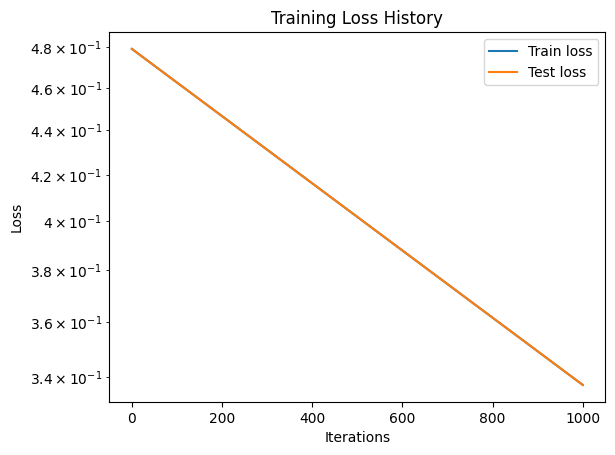

In [21]:
# Plot loss history
dde.utils.external.plot_loss_history(losshistory)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss History")
# Set y-axis to log scale
plt.yscale('log')
plt.show()

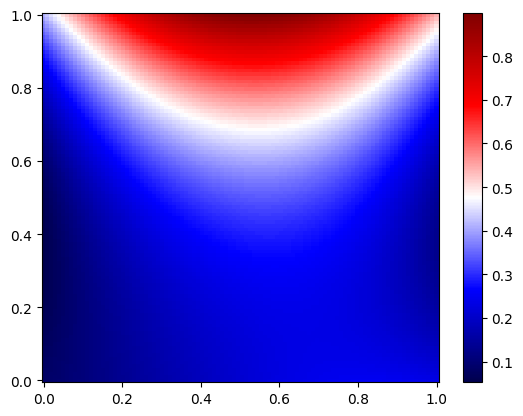

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a grid over the domain
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Stack and reshape for prediction
XY = np.vstack((X.ravel(), Y.ravel())).T

# Predict using the model
T = model.predict(XY)
T = T.reshape(X.shape)

# Plot
plt.pcolor(X, Y, T, cmap='seismic', shading='auto')
plt.colorbar()
plt.show()